In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import sys
sys.path.append('/kaggle/usr/lib')

from basic_preprocessing_utility_script import process_as_h5, signature, get_eeg_sp_data

import numpy as np
import pandas as pd
import os
import time
import h5py
from tqdm import tqdm

import iisignature as isig

import matplotlib.pyplot as plt

In [4]:
filename = '/kaggle/input/hms-harmful-brain-activity-classification/train.csv'
process_as_h5(filename, num_examples = 1000)


100%|██████████| 1000/1000 [01:16<00:00, 13.06it/s]


Files created!


In [16]:
hdf5_file = '/kaggle/working/hdf5/processed_dataset_0_999.h5'
num_examples = 1000



with h5py.File(hdf5_file, 'r') as file:
    # List all groups
    
    print("Keys: %s" % file.keys())
    
    file_keys = list(file.keys())

    a_group_key = list(file.keys())[0]
    
    eeg_data = np.array(file[f"eeg"])
    sp_data = np.array(file[f"sp"])
    targets = np.array(file[f"targets"])
    num_votes = np.array(file[f"num_votes"])
    num_votes = num_votes.reshape((len(num_votes), -1))
    

Keys: <KeysViewHDF5 ['eeg', 'num_votes', 'sp', 'targets']>


In [6]:
def signature_w_concat(data, level=2, chunk_len=None, concatenate=True):
    """Performs signature on data needs data to be 3d,
    
    if input to isig.sig is (num_examples, num_time_steps, dim_of_data_at_each_time_step)
    then the output will be (num_examples, isig.sig_length(dim_of_data_at_each_time_step, level))
    
    chunk_len will split the timesteps (i.e. the second dimension) into chunks of length chunk_len
    
    
    """
    assert len(data.shape) == 3, f"data needs to be 3d. data is {data.shape} If it is 2d, reshape so first dim is 1"
    
    if chunk_len is not None:
        assert chunk_len < data.shape[2], f"chunk length is bigger than the number of time steps"
    
    if chunk_len is None:
        sig_len = isig.siglength(data.shape[2], level)
        assert sig_len > 0 , "Too many elements in each chunk. Signature package thinks the num of elements is negative lol"
    
    if chunk_len is not None:
        sig_len = isig.siglength(data.shape[2], level)
        assert sig_len > 0 , "Too many elements in each chunk. Signature package thinks the num of elements is negative lol"
    
    if chunk_len is None:        
        return isig.sig(data, level) # np.array(sig_arr)
        
    else:
        num_whole_chunks = (data.shape[1] // chunk_len)
        remainder = data.shape[1] % chunk_len

        sig_arr = []

        for j in range(1,num_whole_chunks):
            sub_dat = data[:, j*chunk_len: (j+1)*chunk_len, :]
            sig_output = isig.sig(sub_dat, level)
            sig_arr.append(sig_output.reshape(sig_output.shape[0], 1, sig_output.shape[1]))

        # Handling the remainder if it exists
        if remainder != 0:
            sub_dat = data[:, num_whole_chunks*chunk_len:, ]
            sig_output = isig.sig(sub_dat, level)
            sig_arr.append(sig_output.reshape(sig_output.shape[0], 1, sig_output.shape[1]))

        if concatenate:
            return np.concatenate(sig_arr, axis=1)
        else:
            return sig_arr

In [7]:
from sklearn.manifold import MDS
from sklearn.datasets import load_digits

from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

In [12]:
def signature_op(arr):
    if len(arr.shape) == 2:
        arr = arr[None,:,:]
        
    
    sig_arr = signature_w_concat(arr, level=2, chunk_len = 20, concatenate=False)
    sig_mat = np.concatenate(sig_arr, axis=1).squeeze()
    mds_1000 = MDS(n_components=400, random_state=42)
    sig_mat = mds_1000.fit_transform(sig_mat)
    sig_mat = scaler.fit_transform(sig_mat)
    sig_mat = sig_mat[None,:,:]
    sig_mat = signature_w_concat(sig_mat, level=2, chunk_len = None, concatenate=True)
    sig_mat = sig_mat.reshape((1, 400, 401))
    return sig_mat

In [17]:
print(sp_data.shape)

(1000, 4, 300, 100)


In [18]:
sp_data = sp_data.reshape((-1,300,400))

sp_data.shape

(1000, 300, 400)

In [33]:
#problem at 
sp_sig_arr = [signature_op(sp) for sp in sp_data if sum(np.isnan(sp.flatten())) == 0]

# for i in range(len(sp_data)):
#     # sp_sig_arr = [signature_op(sp) for sp in sp_data]
#     signature_op(sp_data[i])
    

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_st

In [29]:
# #Problem at 74
# num_nans = 0
# num_counts = []

# for i in range(len(sp_data)):
#     if sum(np.isnan(sp_data[i].flatten())) > 0:
#         num_counts.append(sum(np.isnan(sp_data[i].flatten())))
#         num_nans +=1

# print(num_nans)
# print(num_nans / len(sp_data))
# print(num_counts)
# # print(sp_data[74].flatten())

# #sum(np.isnan(sp_data[74].flatten()))

29
0.029
[1200, 1600, 2400, 3200, 4400, 5200, 5600, 6000, 6400, 25200, 9600, 11600, 11600, 11600, 49600, 51600, 56000, 56400, 57600, 58000, 58400, 58800, 59200, 60000, 60400, 16400, 14800, 12400, 15200]


In [35]:
np_sp_sig_arr = np.array(sp_sig_arr)

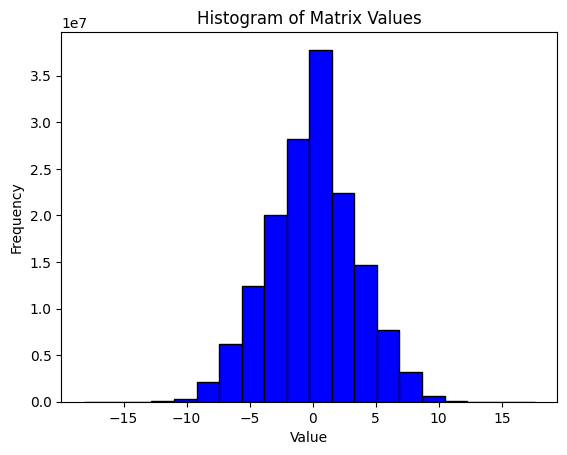

In [36]:
plt.hist(np_sp_sig_arr.flatten(), bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [37]:
np.save('spec_sig_1000.npy', np_sp_sig_arr)

In [43]:
np.save('spec_og_targets_1000.npy', targets * num_votes)